<a href="https://colab.research.google.com/github/Balogunhabeeb14/Petroleum-Target-Xplorer/blob/main/Xpl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Add this
import warnings
warnings.filterwarnings("ignore")

In [23]:
# Load all sheets from the Excel file
file_path='/Users/habeeb/Downloads/Git/ML/Petroleum-Target-Xplorer/Data/Excel Sheets/Passey.xlsx'
dfs=load_excel_sheets(file_path)

# Create list of tuples containing DataFrame and sheet name
df_list = [(df, sheet_name) for sheet_name, df in dfs.items()]

DataFrame loaded successfully for sheet: Data Summary
DataFrame loaded successfully for sheet: TOC-ESTM (KR-2)
DataFrame loaded successfully for sheet: TOC-ESTM (KR-3) (edittt)
DataFrame loaded successfully for sheet: TOC-ESTM (KR-3)
DataFrame loaded successfully for sheet: Sheet2
DataFrame loaded successfully for sheet: Sheet1


In [24]:
# Access the loaded DataFrames
data_summary_df = dfs['Data Summary']
KR2 = dfs['TOC-ESTM (KR-2)']
KR3_edit = dfs['TOC-ESTM (KR-3) (edittt)']
KR3=dfs['TOC-ESTM (KR-3)']
sheet2_df = dfs['Sheet2']
sheet1_df = dfs['Sheet1']

In [25]:
data_summary_df.head(40)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,DATA,NaN,Kolmani River -2,Kolmani River -3
1,Well Head,NaN,Y,Y
2,Deviation data,NaN,Y,Y
3,Litho-logs,Spectral Gamma,Y,N
4,NaN,GR,Y,Y
5,NaN,SP,N,N
6,NaN,Mud-log,Y,Y
7,NaN,Caliper,Y,Y
8,Porosity,DT,Y,Y
9,NaN,RHOB,Y,Y


The data summary provides us with the metadata for the data. Herein, few observations found includes:

- Litho-logs comprise features {Spectral Gamma, GR, SP, Mud-log, Caliper}
- Porosity	comprises features {DT,	RHOB, CNL}
- RES	comprises features {LLD, LLS}
- Biostratigraphic Data
- Well-Tops/Formation Tops
- Reports	comprises features {Geologic,	Rock-Eval}
- Rock-Eval	comprises features {S1, S2, S3,	HI,	OI, VR,	TOC, Tmax}

These features were collected mostly for Kolmani river 2(KR2) and Kolmani river 3(KR3). To have a fair analysis, we will only include features that are available in both KR2 & KR3.

PS. Most of the Multivariate linear regression analysis was repeated to confirm the dependent variable, what was discovered was that, the TOC(measured) was the actual variable predicted across all analysis.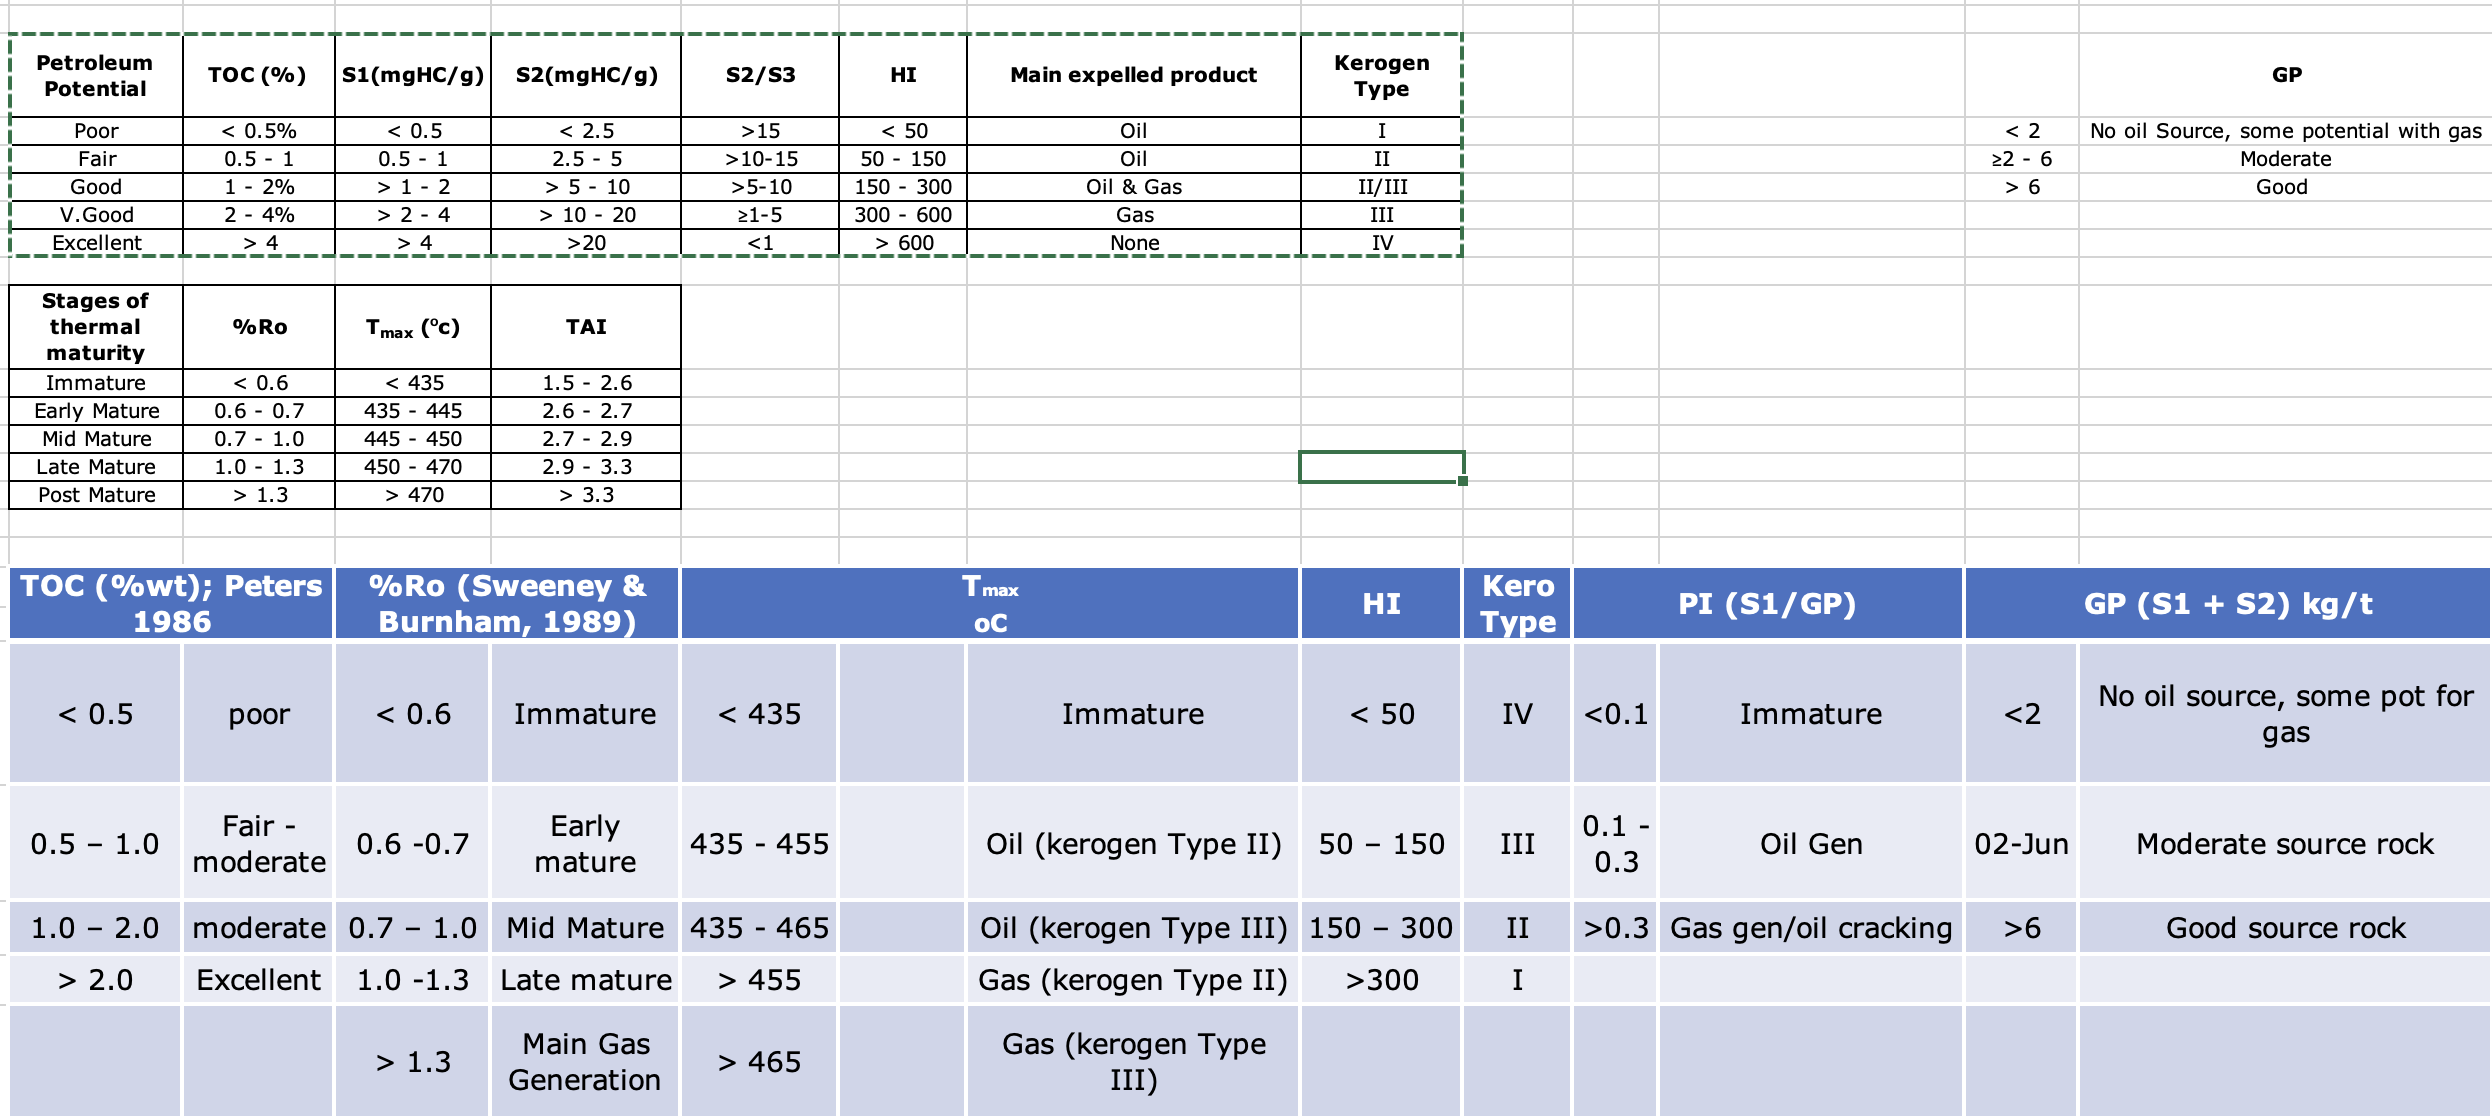



In [26]:
# Drop 'MD' column from KR2 dataframe
KR2 = KR2.drop('MD', axis=1)

# Drop 'MD'
#measure Toc and Measured-TOC.1 in KR3 are same, so we drop one
# Drop 'Measured-TOC.1' column from KR3 dataframe, likwise TOC RK eval
KR3 = KR3.drop(['MD','Measured-TOC.1','TOC (Rk-Eval)'], axis=1)

#This is because in the MVA, there was no signle equation that considered MD, TOC (Rk-Eval)
# Drop unnamed columns from the DataFrame
KR2 = drop_unnamed_columns(KR2)
KR3 = drop_unnamed_columns(KR3)

In [27]:
#names of the KR2 columns
KR2.columns

Index(['Automated Section/Plots', 'Pot-Source', 'Source/Non-Source', 'RES',
       'GR', 'RES.1', 'DT', 'RHOB', 'NEU', 'AI', 'LOM', 'TOC (Schmoker)',
       'log10(Res)', 'Shifted Log10(Res)', 'log10(RHOB)', 'log10(DT)',
       'log10(NEU)', 'DLR RHOB', 'ΔLogR', 'TOC-Pas (LOM8)', 'TOC-Pas (LOM10)',
       'TOC-Pas (LOM11)', 'TOC-Pas (LOM12)', 'TOC-Pas (LOM8)+0.8',
       'TOC-Pas (LOM10)+0.8', 'TOC-Pas (LOM11)+0.8', 'TOC-Pas (LOM12)+0.8',
       'TOC (M-Pas-LOM10)', 'TOC (M-Pas-LOM11)', 'TOC (M-Pas-LOM12)',
       'TOC (M-Pas-LOM10) +0.8', 'TOC (M-Pas-LOM11) +0.8',
       'TOC (M-Pas-LOM12) +0.8', 'TOC    (M-Pas)', 'TOC    (Schm)',
       'TOC (GR, RHOB)', 'TOC (GR, RHOB,NPHI)', 'TOC (GR, RHOB,DT)',
       'TOC (Rk-Eval)', 'Measured-TOC', 'STDEV'],
      dtype='object')

In [28]:
# names of the Kr3 columns
KR3.columns

Index(['AUTOMATED SECTION', 'Source/Non-source', 'Gamma-Ray', 'R90', 'RHOB',
       'Neutron', 'P-sonic', 'LOM', 'AI', 'S-imp.', 'P/S vel.ratio',
       'Poissons ratio', 'Lambda*Rho', 'Mu*Rho', 'Log10(RES)', 'ΔLogR',
       'TOC-Pas (LOM8)', 'TOC-Pas (LOM10)', 'TOC-Pas (LOM11)',
       'TOC-Pas (LOM12)', 'TOC-Pas (LOM8)+0.8', 'TOC-Pas (LOM10)+0.8',
       'TOC-Pas (LOM11)+0.8', 'TOC-Pas (LOM12)+0.8', 'TOC (M-Pas-LOM10)',
       'TOC (M-Pas-LOM11)', 'TOC (M-Pas-LOM12)', 'TOC (M-Pas-LOM11) +0.8',
       'TOC (M-Pas-LOM12) +0.8', 'TOC    (RHOB)', 'TOC (GR, RHOB)',
       'TOC (GR, RHOB,NPHI)', 'TOC (GR, RHOB,DT)', 'Measured-TOC',
       'STDEV (TOC-Passey vs TOC-Rx Eval)',
       'STDEV (TOC-M-Passey vs TOC-Rx Eval)',
       'STDEV (TOC-GR-RHOB vs TOC-Rx Eval)', 'STDEV'],
      dtype='object')

In [29]:
missing_value_percent(KR2)

,Column,Missing_Percent
0,Automated Section/Plots,99.958608
1,Pot-Source,100.000000
2,Source/Non-Source,99.997043
3,RES,99.952695
4,GR,0.002957
5,RES.1,0.002957
6,DT,0.002957
7,RHOB,0.002957
8,NEU,0.002957
9,AI,98.515803


In [30]:
 missing_value_percent(KR3)

,Column,Missing_Percent
0,AUTOMATED SECTION,100.000000
1,Source/Non-source,99.968042
2,Gamma-Ray,29.008341
3,R90,27.921767
4,RHOB,27.809913
5,Neutron,28.701544
6,P-sonic,27.809913
7,LOM,72.711003
8,AI,27.809913
9,S-imp.,27.809913


In [31]:
KR2.describe().T

,count,mean,std,min,25%,50%,75%,max
Pot-Source,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR,33822.0,68.163080,570.921839,-9999.000000,75.592525,91.163400,117.229975,247.242700
RES.1,33822.0,31.223275,115.871232,-9999.000000,7.125050,12.190400,29.606275,1999.390000
DT,33822.0,39.311113,599.334320,-9999.000000,62.662375,67.533950,76.773700,171.481400
RHOB,33822.0,1.072673,121.598205,-9999.000000,2.508900,2.558600,2.604000,2.962500
NEU,33822.0,1.247301,361.121576,-9999.000000,6.149450,9.728550,16.555600,73.249700
AI,502.0,156.674956,11.540989,126.738809,149.857818,153.770631,159.811026,219.969938
LOM,7881.0,10.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000
TOC (Schmoker),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log10(Res),2395.0,1.754149,0.242531,0.968996,1.575318,1.784285,1.950982,2.261546


In [32]:
KR3.describe().T

,count,mean,std,min,25%,50%,75%,max
AUTOMATED SECTION,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gamma-Ray,22214.0,1.153963e+02,3.536899e+01,32.710000,8.749000e+01,1.093000e+02,1.383900e+02,2.343000e+02
R90,22554.0,1.522819e+01,9.609492e+01,0.516500,2.998350e+00,8.871200e+00,1.489443e+01,2.000000e+03
RHOB,22589.0,-8.163732e+00,1.029226e+02,-999.250000,2.484700e+00,2.540400e+00,2.586300e+00,2.723200e+00
Neutron,22310.0,1.627761e-01,9.229879e-02,-0.012900,9.380000e-02,1.345000e-01,2.385000e-01,6.039000e-01
P-sonic,22589.0,7.522636e+01,7.879241e+01,-999.250000,6.557000e+01,7.239000e+01,9.230000e+01,1.368800e+02
LOM,8539.0,1.000000e+01,0.000000e+00,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
AI,22589.0,3.256898e+04,8.388900e+03,-999.250000,2.686321e+04,3.446803e+04,3.872412e+04,4.859355e+04
S-imp.,22589.0,1.847587e+04,6.615405e+03,-999.250000,1.323555e+04,2.006530e+04,2.354492e+04,3.180393e+04
P/S vel.ratio,22589.0,-7.710150e+00,9.742871e+01,-999.250000,1.640000e+00,1.710000e+00,1.970000e+00,2.980000e+00


In [33]:
#drop columns with more than 70% missingness
KR2 = drop_high_missing_columns(KR2, threshold=70)
KR3 = drop_high_missing_columns(KR3, threshold=70)

In [34]:
KR2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33823 entries, 0 to 33822
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GR            33822 non-null  float64
 1   RES.1         33822 non-null  float64
 2   DT            33822 non-null  float64
 3   RHOB          33822 non-null  float64
 4   NEU           33822 non-null  float64
 5   ΔLogR         25105 non-null  float64
 6   Measured-TOC  33817 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB


In [35]:
KR3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31291 entries, 0 to 31290
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Gamma-Ray                            22214 non-null  float64
 1   R90                                  22554 non-null  float64
 2   RHOB                                 22589 non-null  float64
 3   Neutron                              22310 non-null  float64
 4   P-sonic                              22589 non-null  float64
 5   AI                                   22589 non-null  float64
 6   S-imp.                               22589 non-null  float64
 7   P/S vel.ratio                        22589 non-null  float64
 8   Poissons ratio                       22589 non-null  float64
 9   Lambda*Rho                           22589 non-null  float64
 10  Mu*Rho                               22589 non-null  float64
 11  Log10(RES)                  

In [36]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def check_normality(df):
    """
    Check the normality of features in a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        None
    """
    for column in df.columns:
        plt.figure(figsize=(10, 4))

        # Histogram
        plt.subplot(1, 2, 1)
        df[column].plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

        # Q-Q plot
        plt.subplot(1, 2, 2)
        stats.probplot(df[column].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {column}')
        plt.xlabel('Theoretical quantiles')
        plt.ylabel('Sample quantiles')

        plt.tight_layout()
        plt.show()

        # Shapiro-Wilk test for normality
        stat, p = stats.shapiro(df[column].dropna())
        print(f'Feature: {column}, Shapiro-Wilk Test Statistic: {stat}, p-value: {p}')
        if p > 0.05:
            print(f"The feature '{column}' appears to be approximately normally distributed.\n")
        else:
            print(f"The feature '{column}' does not appear to be normally distributed.\n")

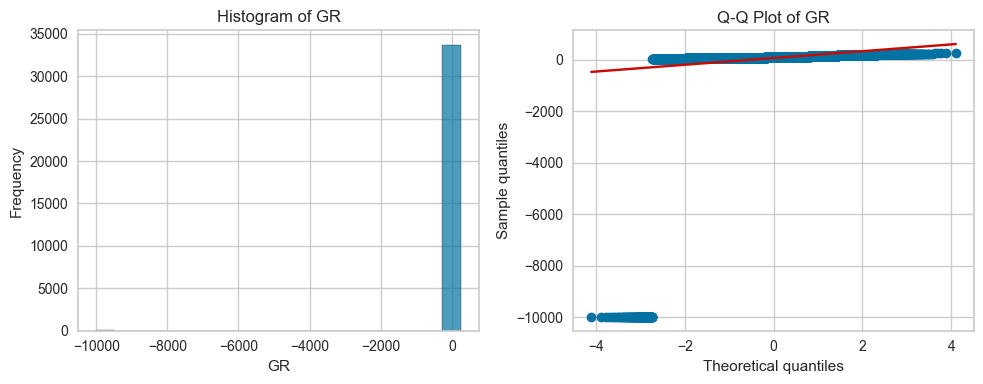

Feature: GR, Shapiro-Wilk Test Statistic: 0.053385376930236816, p-value: 0.0
The feature 'GR' does not appear to be normally distributed.



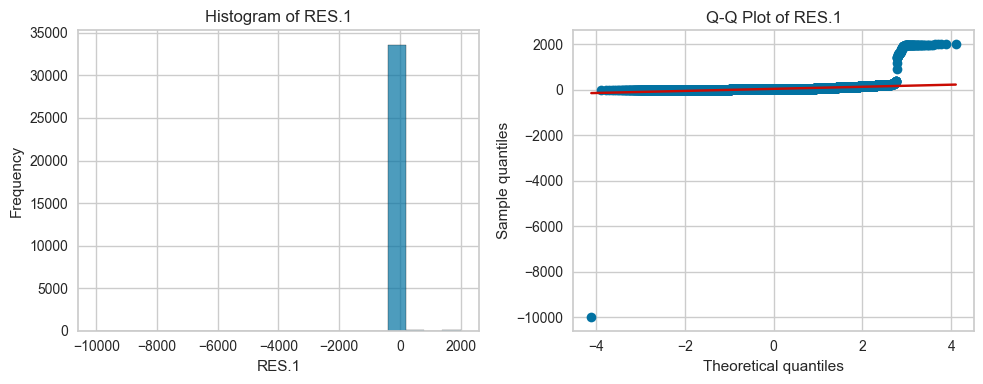

Feature: RES.1, Shapiro-Wilk Test Statistic: 0.15540558099746704, p-value: 0.0
The feature 'RES.1' does not appear to be normally distributed.



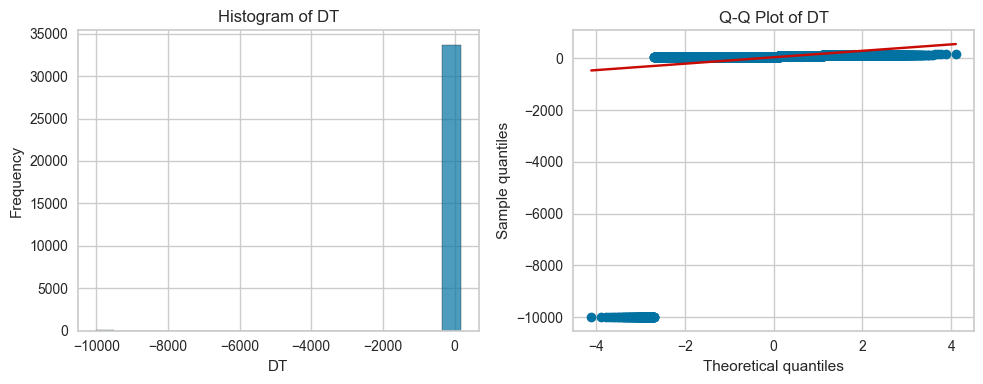

Feature: DT, Shapiro-Wilk Test Statistic: 0.0430753231048584, p-value: 0.0
The feature 'DT' does not appear to be normally distributed.



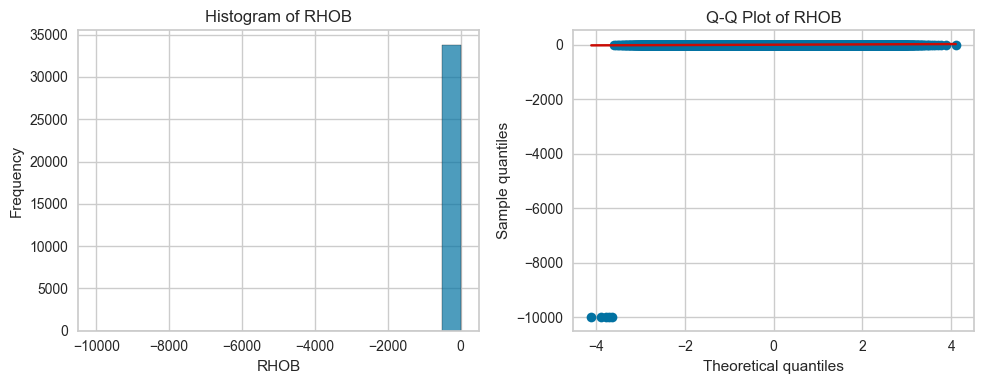

Feature: RHOB, Shapiro-Wilk Test Statistic: 0.002294182777404785, p-value: 0.0
The feature 'RHOB' does not appear to be normally distributed.



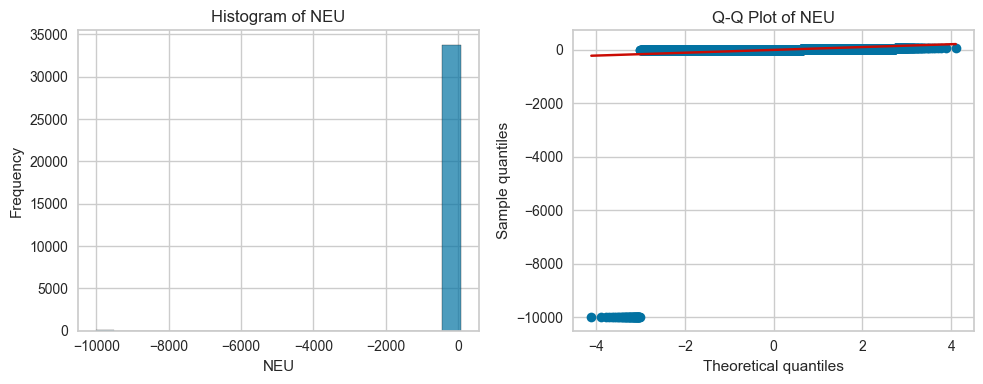

Feature: NEU, Shapiro-Wilk Test Statistic: 0.021808981895446777, p-value: 0.0
The feature 'NEU' does not appear to be normally distributed.



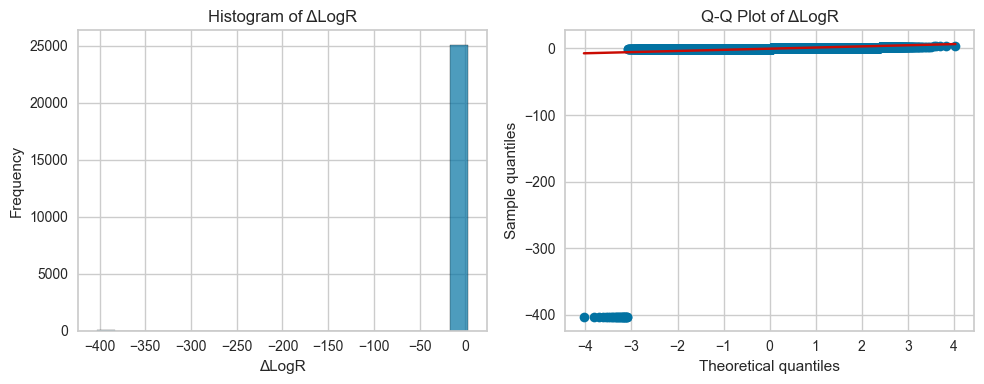

Feature: ΔLogR, Shapiro-Wilk Test Statistic: 0.01835334300994873, p-value: 0.0
The feature 'ΔLogR' does not appear to be normally distributed.



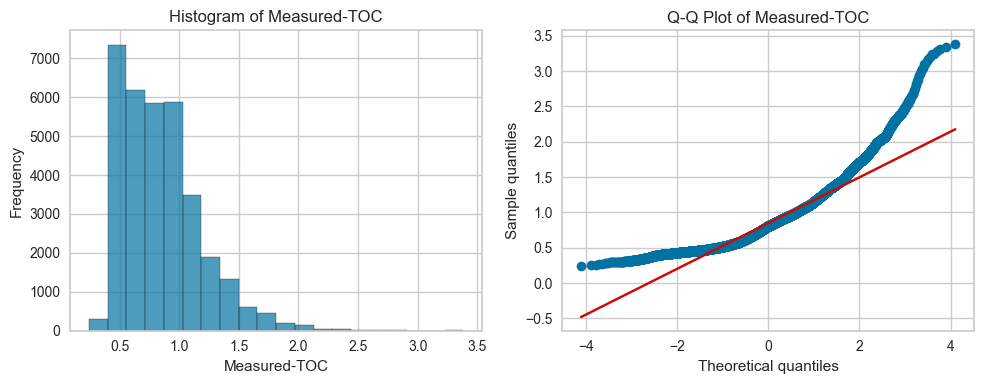

Feature: Measured-TOC, Shapiro-Wilk Test Statistic: 0.9134657382965088, p-value: 0.0
The feature 'Measured-TOC' does not appear to be normally distributed.



In [37]:
check_normality(KR2)

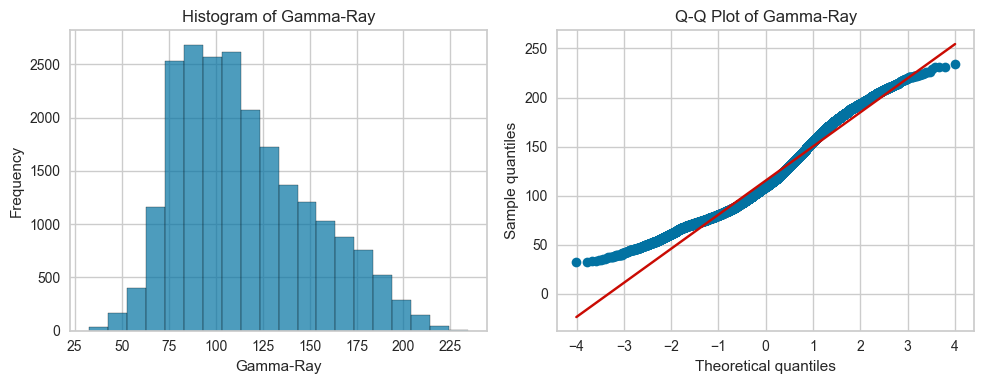

Feature: Gamma-Ray, Shapiro-Wilk Test Statistic: 0.9647457599639893, p-value: 0.0
The feature 'Gamma-Ray' does not appear to be normally distributed.



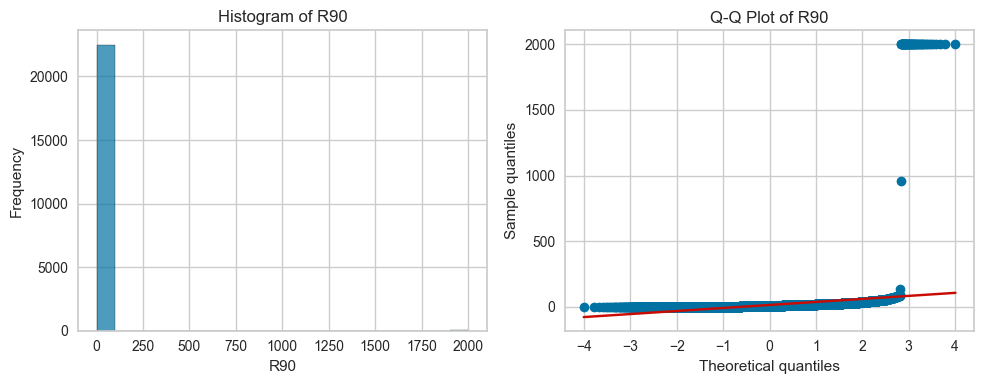

Feature: R90, Shapiro-Wilk Test Statistic: 0.057448744773864746, p-value: 0.0
The feature 'R90' does not appear to be normally distributed.



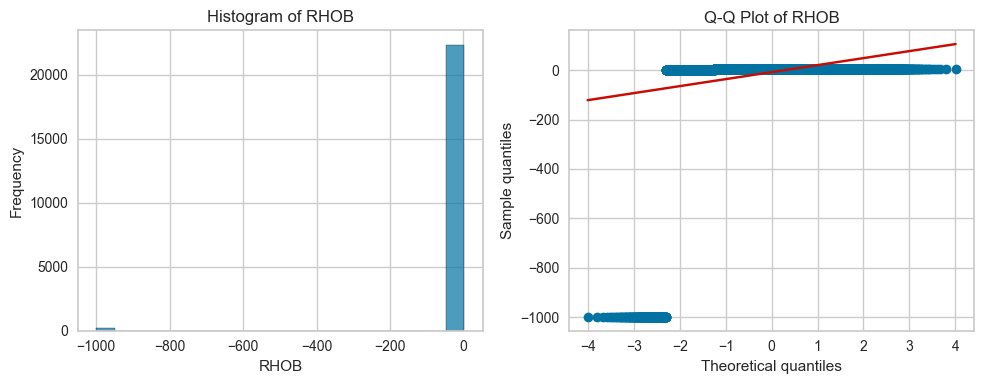

Feature: RHOB, Shapiro-Wilk Test Statistic: 0.07580512762069702, p-value: 0.0
The feature 'RHOB' does not appear to be normally distributed.



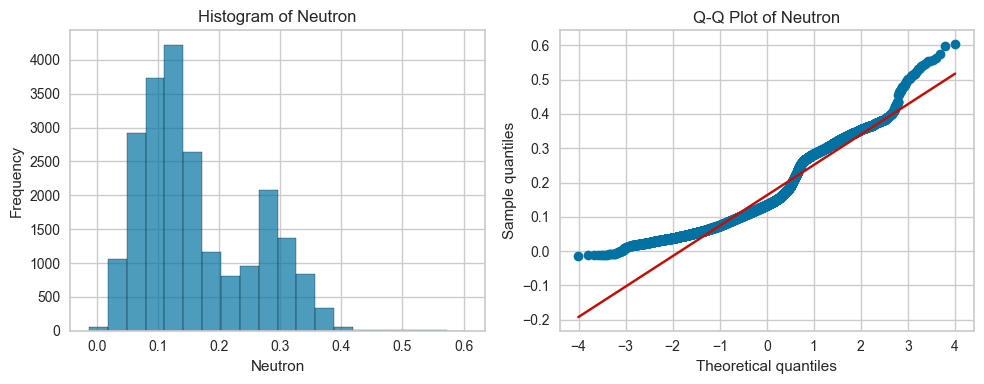

Feature: Neutron, Shapiro-Wilk Test Statistic: 0.9216905236244202, p-value: 0.0
The feature 'Neutron' does not appear to be normally distributed.



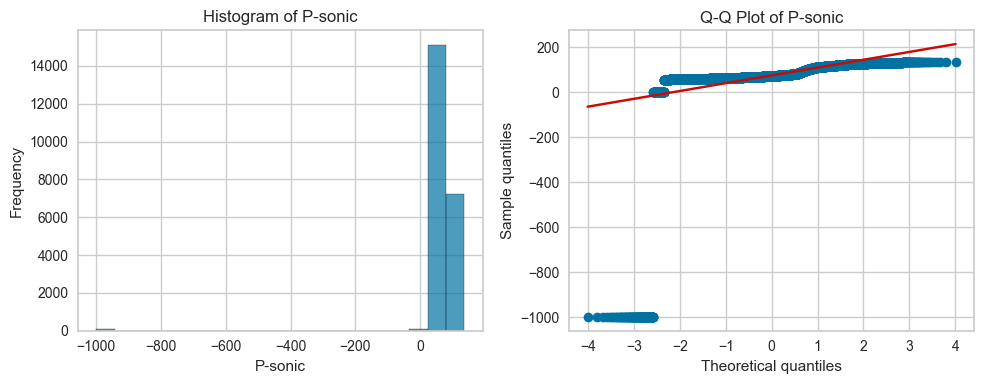

Feature: P-sonic, Shapiro-Wilk Test Statistic: 0.19456708431243896, p-value: 0.0
The feature 'P-sonic' does not appear to be normally distributed.



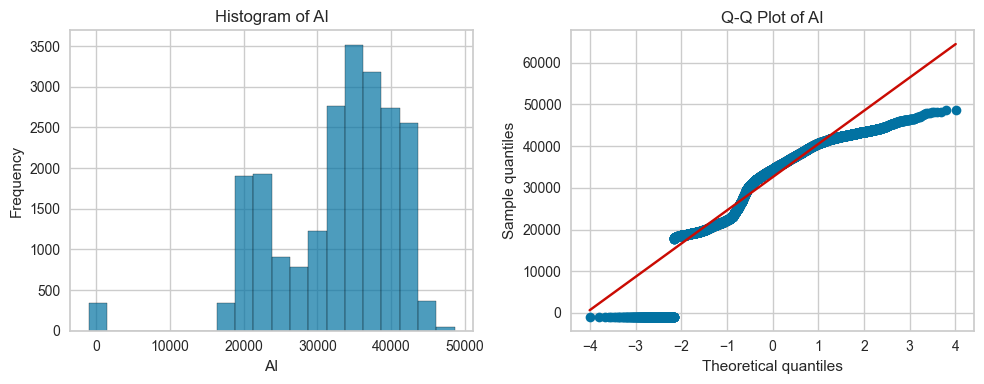

Feature: AI, Shapiro-Wilk Test Statistic: 0.9017176032066345, p-value: 0.0
The feature 'AI' does not appear to be normally distributed.



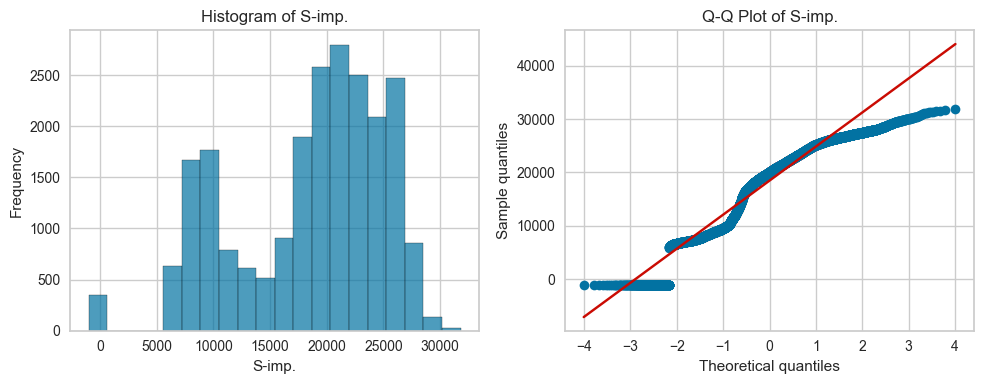

Feature: S-imp., Shapiro-Wilk Test Statistic: 0.9296411275863647, p-value: 0.0
The feature 'S-imp.' does not appear to be normally distributed.



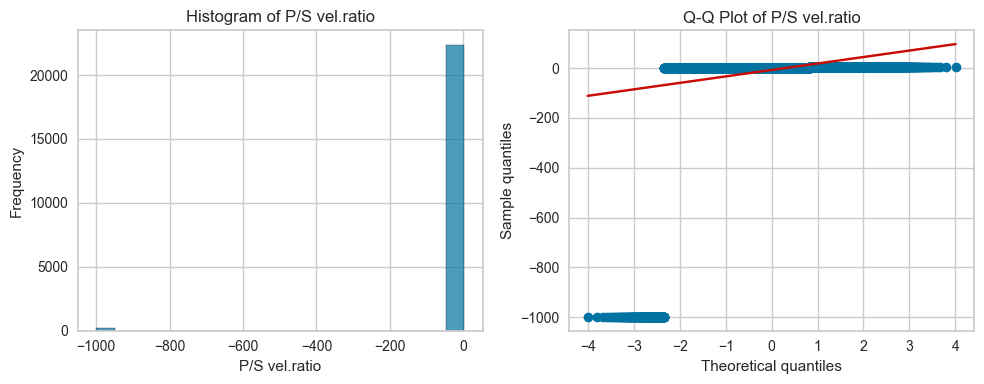

Feature: P/S vel.ratio, Shapiro-Wilk Test Statistic: 0.0708422064781189, p-value: 0.0
The feature 'P/S vel.ratio' does not appear to be normally distributed.



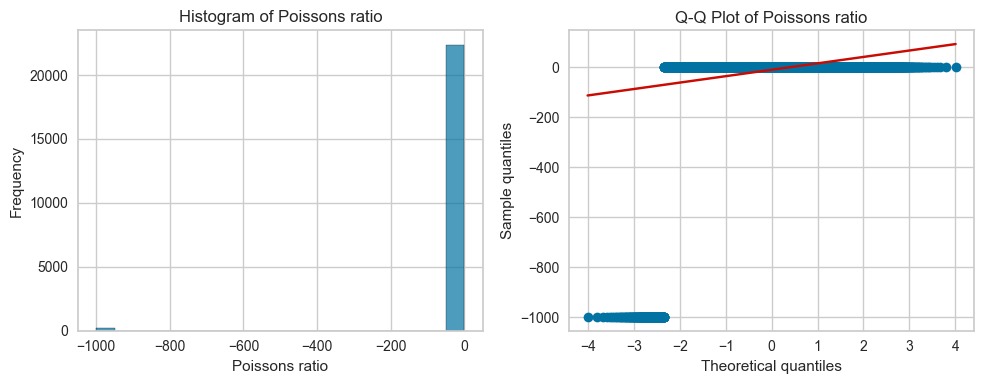

Feature: Poissons ratio, Shapiro-Wilk Test Statistic: 0.06974297761917114, p-value: 0.0
The feature 'Poissons ratio' does not appear to be normally distributed.



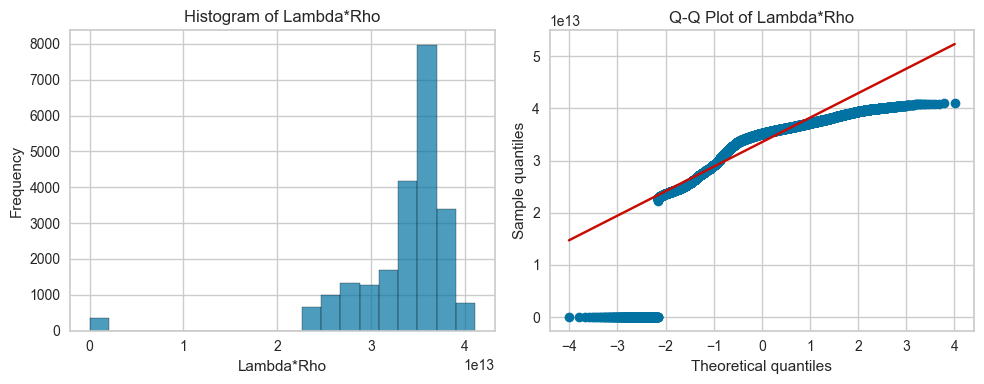

Feature: Lambda*Rho, Shapiro-Wilk Test Statistic: 0.6897604465484619, p-value: 0.0
The feature 'Lambda*Rho' does not appear to be normally distributed.



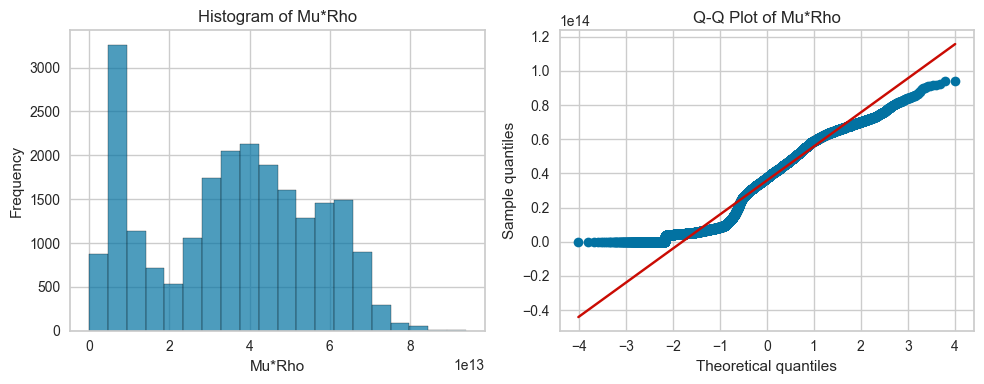

Feature: Mu*Rho, Shapiro-Wilk Test Statistic: 0.9568662047386169, p-value: 0.0
The feature 'Mu*Rho' does not appear to be normally distributed.



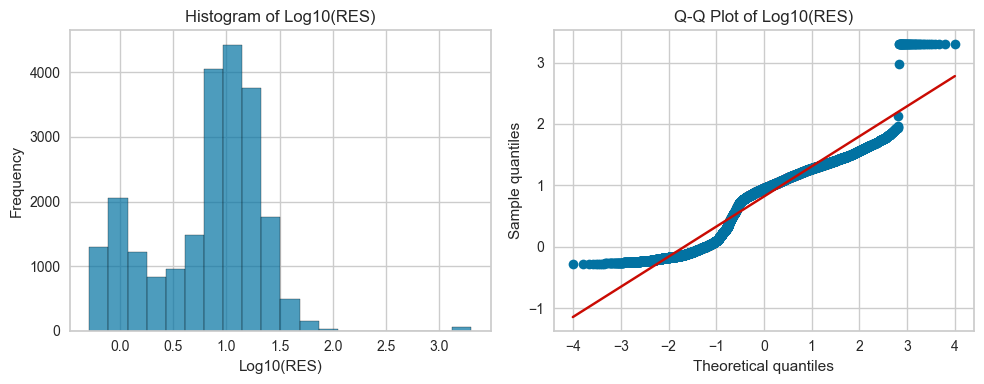

Feature: Log10(RES), Shapiro-Wilk Test Statistic: 0.9200841784477234, p-value: 0.0
The feature 'Log10(RES)' does not appear to be normally distributed.



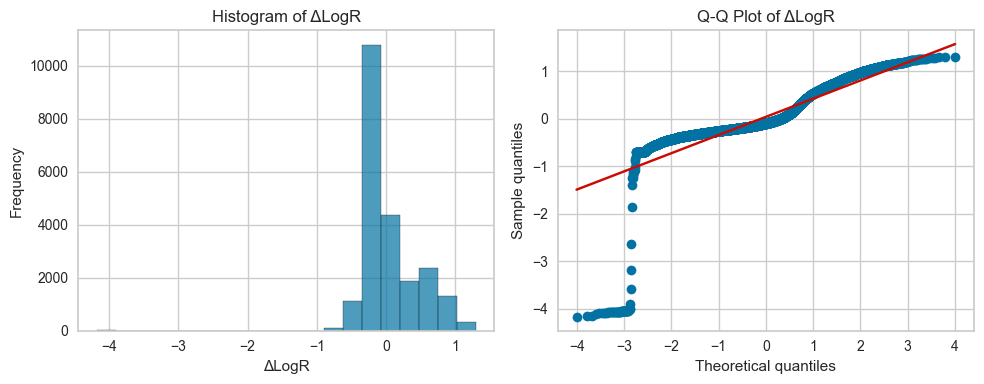

Feature: ΔLogR, Shapiro-Wilk Test Statistic: 0.8050466179847717, p-value: 0.0
The feature 'ΔLogR' does not appear to be normally distributed.



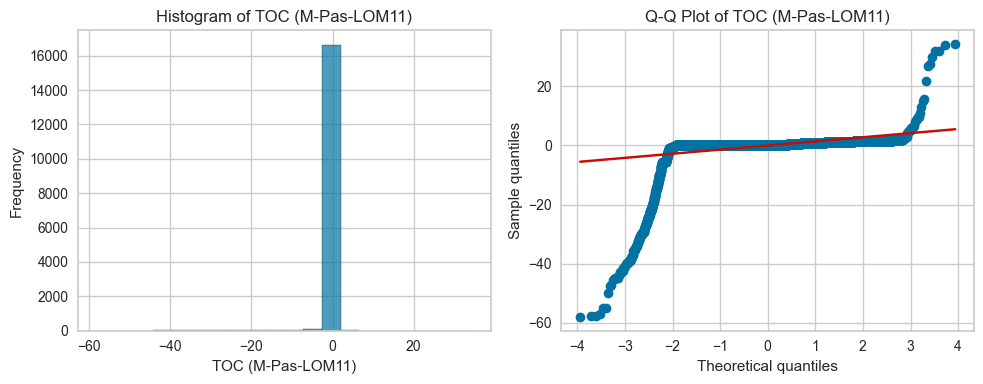

Feature: TOC (M-Pas-LOM11), Shapiro-Wilk Test Statistic: 0.18195635080337524, p-value: 0.0
The feature 'TOC (M-Pas-LOM11)' does not appear to be normally distributed.



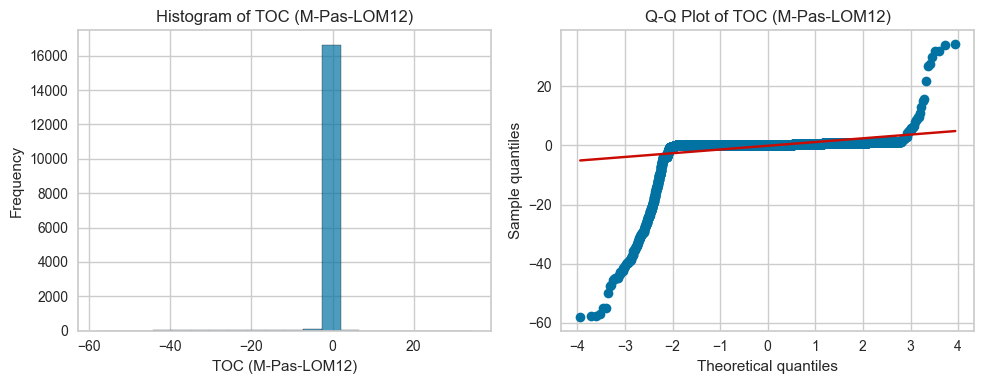

Feature: TOC (M-Pas-LOM12), Shapiro-Wilk Test Statistic: 0.1519983410835266, p-value: 0.0
The feature 'TOC (M-Pas-LOM12)' does not appear to be normally distributed.



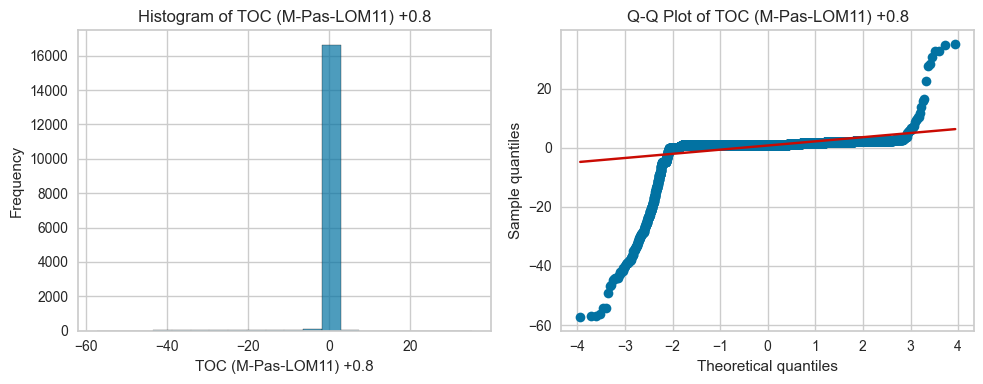

Feature: TOC (M-Pas-LOM11) +0.8, Shapiro-Wilk Test Statistic: 0.18509644269943237, p-value: 0.0
The feature 'TOC (M-Pas-LOM11) +0.8' does not appear to be normally distributed.



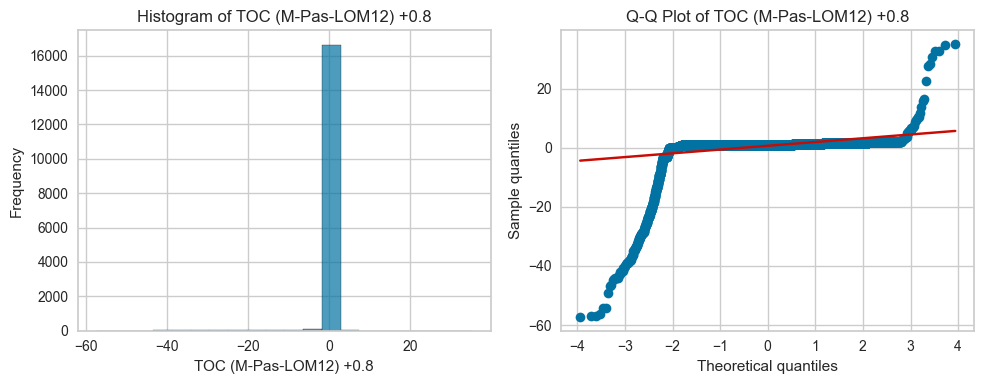

Feature: TOC (M-Pas-LOM12) +0.8, Shapiro-Wilk Test Statistic: 0.15495580434799194, p-value: 0.0
The feature 'TOC (M-Pas-LOM12) +0.8' does not appear to be normally distributed.



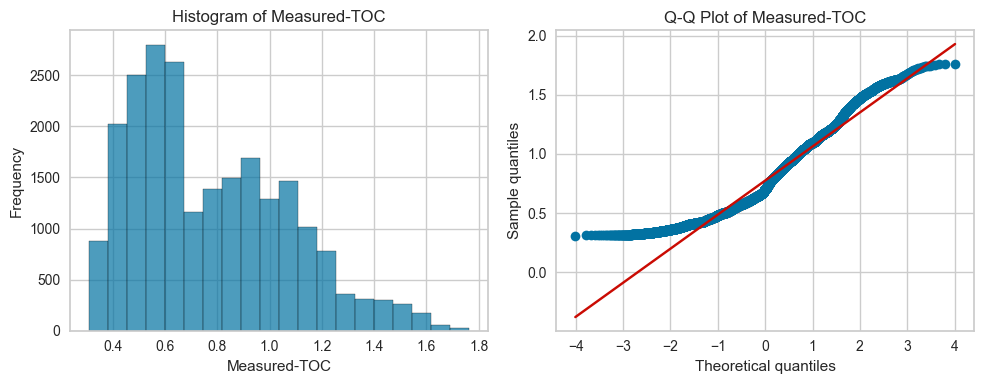

Feature: Measured-TOC, Shapiro-Wilk Test Statistic: 0.9474841356277466, p-value: 0.0
The feature 'Measured-TOC' does not appear to be normally distributed.



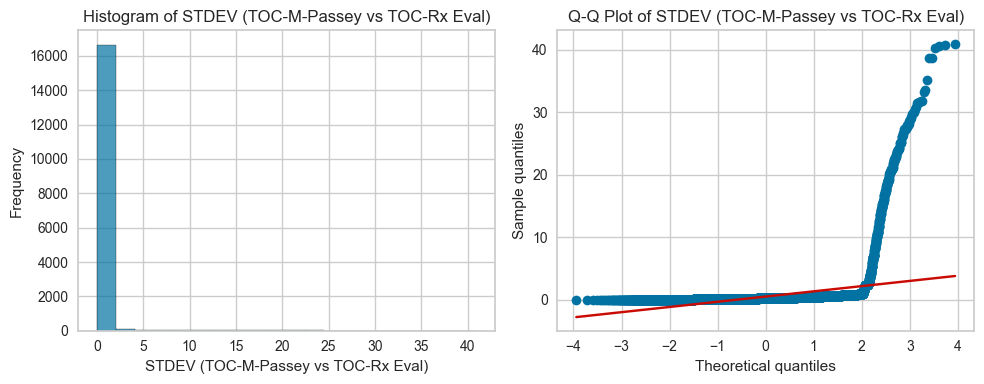

Feature: STDEV (TOC-M-Passey vs TOC-Rx Eval), Shapiro-Wilk Test Statistic: 0.14022177457809448, p-value: 0.0
The feature 'STDEV (TOC-M-Passey vs TOC-Rx Eval)' does not appear to be normally distributed.



In [38]:
check_normality(KR3)

The Statistical MVA is first tried, to investigate the significant features. Mind you we have earlier dropped features with high missingness of over 70% of total. We have as well dropped those that were duplicates.

In [39]:
import pandas as pd
import numpy as np

def impute_missing(df):
    """
    Impute missing values in a DataFrame using appropriate methods based on the data distribution.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        DataFrame: The DataFrame with missing values imputed.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            # For categorical data, impute with mode
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)
            print(f"Imputed missing values in '{column}' with mode: {mode_val}")
        elif np.abs(df[column].skew()) > 1:
            # For highly skewed numerical data, impute with median
            median_val = df[column].median()
            df[column].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{column}' with median: {median_val}")
        else:
            # For approximately normally distributed numerical data, impute with mean
            mean_val = df[column].mean()
            df[column].fillna(mean_val, inplace=True)
            print(f"Imputed missing values in '{column}' with mean: {mean_val}")

    return df


In [40]:
impute_missing(KR2)

Imputed missing values in 'GR' with median: 91.1634
Imputed missing values in 'RES.1' with median: 12.1904
Imputed missing values in 'DT' with median: 67.53395
Imputed missing values in 'RHOB' with median: 2.5586
Imputed missing values in 'NEU' with median: 9.72855
Imputed missing values in 'ΔLogR' with median: -0.1089999633264126
Imputed missing values in 'Measured-TOC' with median: 0.8062875271


,GR,RES.1,DT,RHOB,NEU,ΔLogR,Measured-TOC
0,40.4902,1970.8360,56.5478,1.6991,51.6765,1.556562,0.868600
1,40.3001,1968.4550,56.0224,1.7037,53.4121,1.535021,0.866900
2,38.8794,1966.7630,56.0224,1.7081,50.7708,1.534648,0.865200
3,37.9678,1966.7630,55.3079,1.7130,57.6586,1.506068,0.863500
4,37.4406,1962.9860,55.3079,1.7149,59.4048,1.505233,0.861800
...,...,...,...,...,...,...,...
33818,-9999.0000,42.0689,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.609000
33819,-9999.0000,40.3133,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.591000
33820,-9999.0000,39.0027,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.573000
33821,-9999.0000,37.9896,-9999.0000,-9999.0000,-9999.0000,-0.109000,0.555000


In [41]:
impute_missing(KR3)

Imputed missing values in 'Gamma-Ray' with mean: 115.39626316737193
Imputed missing values in 'R90' with median: 8.8712
Imputed missing values in 'RHOB' with median: 2.5404
Imputed missing values in 'Neutron' with mean: 0.1627760824742268
Imputed missing values in 'P-sonic' with median: 72.39
Imputed missing values in 'AI' with median: 34468.03
Imputed missing values in 'S-imp.' with mean: 18475.87286688211
Imputed missing values in 'P/S vel.ratio' with median: 1.71
Imputed missing values in 'Poissons ratio' with median: 0.24
Imputed missing values in 'Lambda*Rho' with median: 35172490000000.0
Imputed missing values in 'Mu*Rho' with mean: 35777357691250.4
Imputed missing values in 'Log10(RES)' with mean: 0.8161882221526374
Imputed missing values in 'ΔLogR' with median: -0.09771328428108893
Imputed missing values in 'TOC (M-Pas-LOM11)' with median: 0.0
Imputed missing values in 'TOC (M-Pas-LOM12)' with median: 0.0
Imputed missing values in 'TOC (M-Pas-LOM11) +0.8' with median: 0.8
Imput

,Gamma-Ray,R90,RHOB,Neutron,P-sonic,AI,S-imp.,P/S vel.ratio,Poissons ratio,Lambda*Rho,Mu*Rho,Log10(RES),ΔLogR,TOC (M-Pas-LOM11),TOC (M-Pas-LOM12),TOC (M-Pas-LOM11) +0.8,TOC (M-Pas-LOM12) +0.8,Measured-TOC,STDEV (TOC-M-Passey vs TOC-Rx Eval)
0,39.970000,2000.0000,0.0000,0.597800,0.00,-999.25,-999.250000,-999.25,-999.25,-9.992500e+02,-9.992500e+02,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.734000,0.085589
1,39.780000,2000.0000,0.0000,0.603900,0.00,-999.25,-999.250000,-999.25,-999.25,-9.992500e+02,-9.992500e+02,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.735271,0.078518
2,39.300000,2000.0000,0.0000,0.564500,0.00,-999.25,-999.250000,-999.25,-999.25,-9.992500e+02,-9.992500e+02,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.736542,0.078518
3,39.260000,2000.0000,0.0000,0.512000,0.00,-999.25,-999.250000,-999.25,-999.25,-9.992500e+02,-9.992500e+02,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.737813,0.071447
4,39.510000,2000.0000,0.0000,0.504800,0.00,-999.25,-999.250000,-999.25,-999.25,-9.992500e+02,-9.992500e+02,3.301030,-0.698970,-0.971983,-0.658959,-0.171983,0.141041,0.739083,0.071447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31286,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,3.517249e+13,3.577736e+13,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.091924
31287,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,3.517249e+13,3.577736e+13,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.091924
31288,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,3.517249e+13,3.577736e+13,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.091924
31289,115.396263,8.8712,2.5404,0.162776,72.39,34468.03,18475.872867,1.71,0.24,3.517249e+13,3.577736e+13,0.816188,-0.097713,0.000000,0.000000,0.800000,0.800000,0.774628,0.091924


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df):
    """
    Plot correlation matrix and identify multicollinearity.

    Parameters:
        df (DataFrame): The DataFrame containing the features.

    Returns:
        None
    """
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Set the plot style (change 'whitegrid' to other styles like 'darkgrid', 'white', 'dark', or 'ticks')
    sns.set_style("white")

    # Plot heatmap with new colormap and style
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='tab10', fmt=".2f", annot_kws={"size": 8, "color": 'black'})
    plt.title('Correlation Matrix')
    plt.show()

    # Check for multicollinearity
    collinear_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                colname = corr_matrix.columns[i]
                collinear_features.add(colname)

    if collinear_features:
        print("The following variables are highly correlated (>|0.7|):")
        print(collinear_features)
    else:
        print("No multicollinearity detected.")

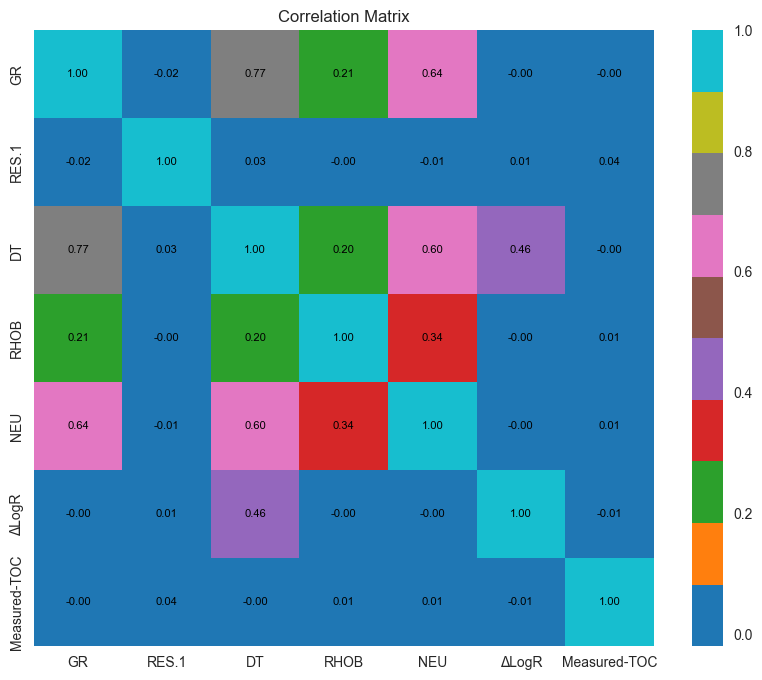

The following variables are highly correlated (>|0.7|):
{'DT'}


In [43]:
plot_correlation_matrix(KR2)

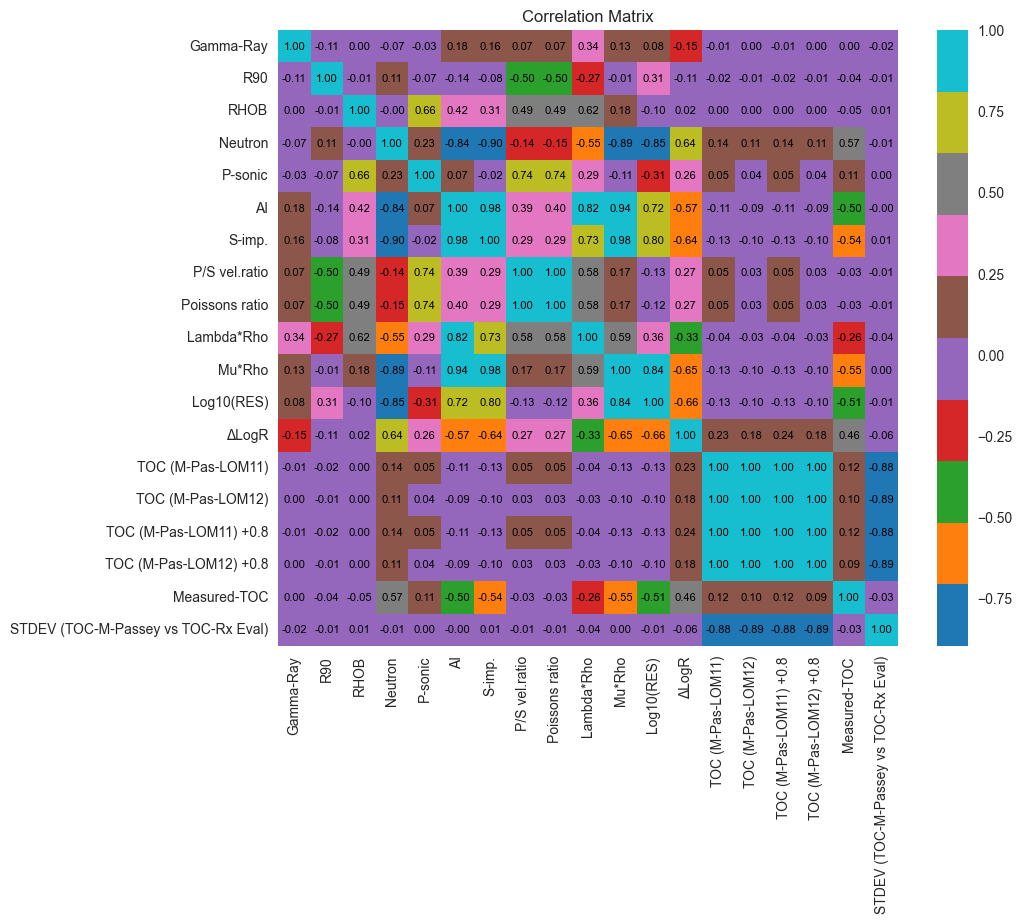

The following variables are highly correlated (>|0.7|):
{'TOC (M-Pas-LOM12)', 'P/S vel.ratio', 'TOC (M-Pas-LOM11) +0.8', 'AI', 'Mu*Rho', 'STDEV (TOC-M-Passey vs TOC-Rx Eval)', 'Poissons ratio', 'S-imp.', 'Lambda*Rho', 'TOC (M-Pas-LOM12) +0.8', 'Log10(RES)'}


In [44]:
plot_correlation_matrix(KR3)

From KR2; DT has a higher correlation, we may want to drop the column however, we will leave that for now. As for Kr3, we have a ton of features 
TOC (M-Pas-LOM12) +0.8', 'S-imp.', 'AI', 'Log10(RES)', 'Lambda*Rho', 'TOC (M-Pas-LOM12)', 'Poissons ratio', 'Mu*Rho', 'STDEV (TOC-M-Passey vs TOC-Rx Eval)', 'P/S vel.ratio', 'TOC (M-Pas-LOM11) +0.8' and we will need to drop them to avoid multicolinearity.

Starting with the KR2:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(9876789)
df1=KR2.copy()
df1=df1.dropna()

# Separate features and target
X_KR2 = df1.drop('Measured-TOC', axis=1)
y_KR2 = df1['Measured-TOC']


#Ordinary least square methods
X_KR2_=sm.add_constant(X_KR2)
model = sm.OLS(y_KR2, X_KR2)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           Measured-TOC   R-squared (uncentered):                   0.085
Model:                            OLS   Adj. R-squared (uncentered):              0.085
Method:                 Least Squares   F-statistic:                              525.3
Date:                Thu, 05 Sep 2024   Prob (F-statistic):                        0.00
Time:                        12:26:36   Log-Likelihood:                         -43424.
No. Observations:               33823   AIC:                                  8.686e+04
Df Residuals:                   33817   BIC:                                  8.691e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


Looking at the summary statistics of the MVA; GR, RES.1, DT, RHOB, NEU are all significant. While the LogR isnt sigficant.

In [46]:
print("Parameters: ", results.params)
print("R2: ", results.rsquared)


Parameters:  GR       0.000334
RES.1    0.001955
DT      -0.000091
RHOB     0.000072
NEU     -0.000237
ΔLogR   -0.000044
dtype: float64
R2:  0.08525358145540107


Lets look at the KR3 MVA;

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(9876789)
df2=KR3.copy()
df2=df2.dropna()

# Separate features and target
X_KR3 = df2.drop('Measured-TOC', axis=1)
y_KR3 = df2['Measured-TOC']


#Ordinary least square methods
X_KR3_=sm.add_constant(X_KR3)
model = sm.OLS(y_KR3, X_KR3)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Measured-TOC   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1721.
Date:                Thu, 05 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:26:36   Log-Likelihood:                 6216.1
No. Observations:               31291   AIC:                        -1.241e+04
Df Residuals:                   31279   BIC:                        -1.231e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Ga

In [48]:
print("Parameters: ", results.params)
print("R2: ", results.rsquared)

Parameters:  Gamma-Ray                             -2.548279e-04
R90                                   -3.706114e-04
RHOB                                  -7.048591e-04
Neutron                                1.217526e-02
P-sonic                                1.408306e-03
AI                                     5.063144e-07
S-imp.                                -7.600229e-05
P/S vel.ratio                          6.263327e-02
Poissons ratio                        -6.423252e-02
Lambda*Rho                             4.224407e-14
Mu*Rho                                 1.491351e-14
Log10(RES)                             2.373544e-03
ΔLogR                                  1.811421e-01
TOC (M-Pas-LOM11)                      3.470273e-02
TOC (M-Pas-LOM12)                     -3.603500e-02
TOC (M-Pas-LOM11) +0.8                 3.647413e-02
TOC (M-Pas-LOM12) +0.8                -3.426360e-02
STDEV (TOC-M-Passey vs TOC-Rx Eval)    4.580808e-03
dtype: float64
R2:  0.3770565106591445


All features in the KR3 except for AI was insignificant.

Feature selections methods using machine learning models: ANOVA, Mutual information, Recursive feature elimination and Boruta(random forest)

KR2

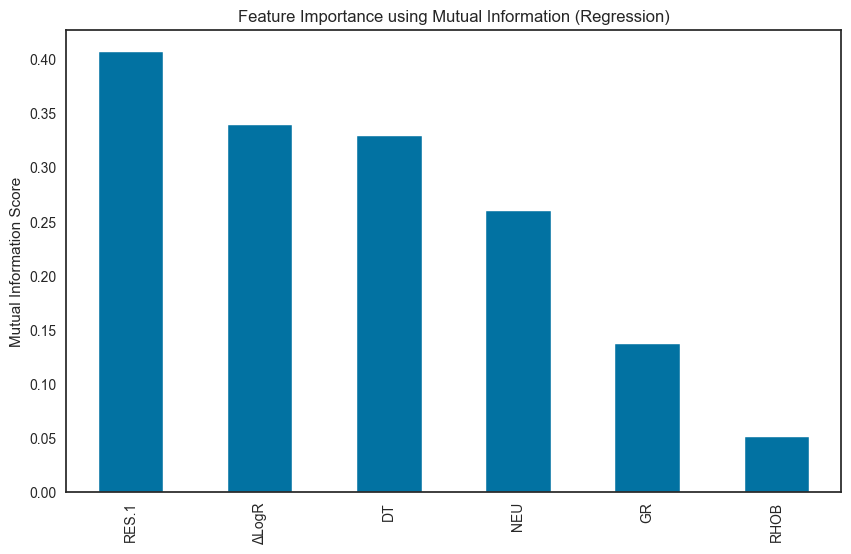

In [49]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd

# Compute Mutual Information for regression
mutual_info = mutual_info_regression(X_KR2, y_KR2)
mutual_info_series = pd.Series(mutual_info, index=X_KR2.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='bar')
plt.title('Feature Importance using Mutual Information (Regression)')
plt.ylabel('Mutual Information Score')
plt.show()


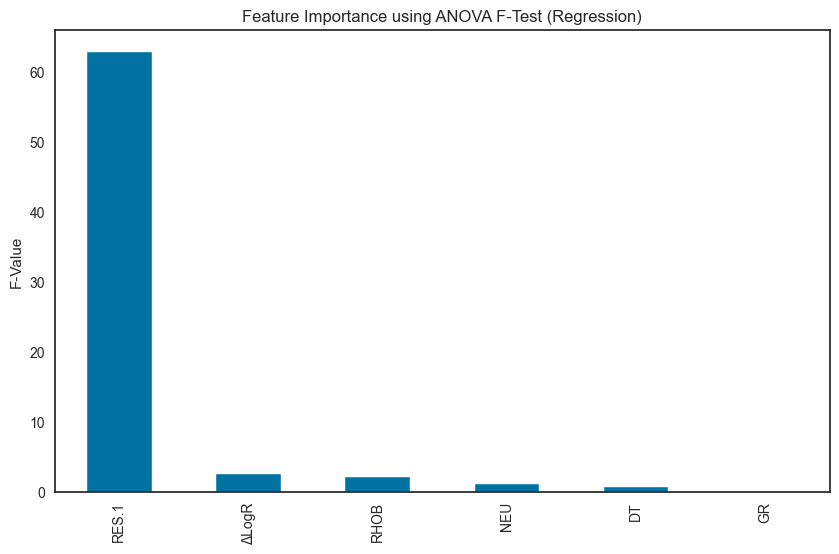

In [50]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt

# Apply ANOVA F-test for regression
selector = SelectKBest(f_regression, k='all')
selector.fit(X_KR2, y_KR2)

# Plot feature importance using F-values
plt.figure(figsize=(10, 6))
pd.Series(selector.scores_, index=X_KR2.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance using ANOVA F-Test (Regression)')
plt.ylabel('F-Value')
plt.show()


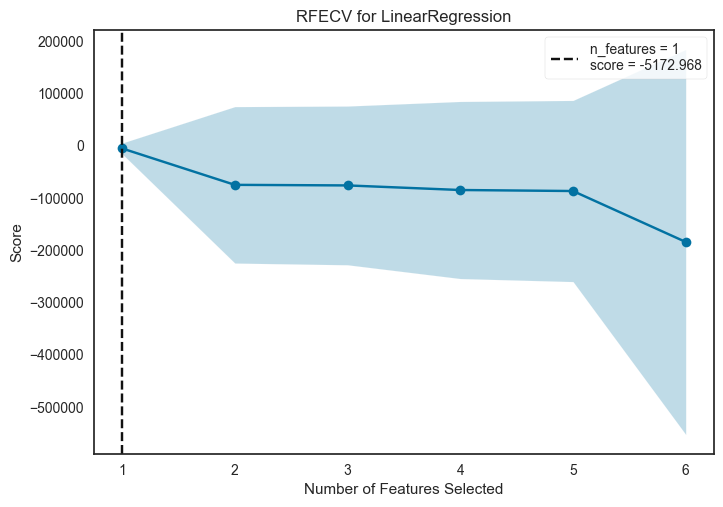

<Axes: title={'center': 'RFECV for LinearRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [51]:
from sklearn.linear_model import LinearRegression
from yellowbrick.model_selection import RFECV

# Initialize the regression model (you can also try RandomForestRegressor or other regression models)
model = LinearRegression()

# Create the RFE visualizer for regression
visualizer = RFECV(model, cv=5, scoring='r2')  # Use R2 score for regression

visualizer.fit(X_KR2, y_KR2)  # Fit the data to the visualizer
visualizer.show()      # Finalize and render the figure


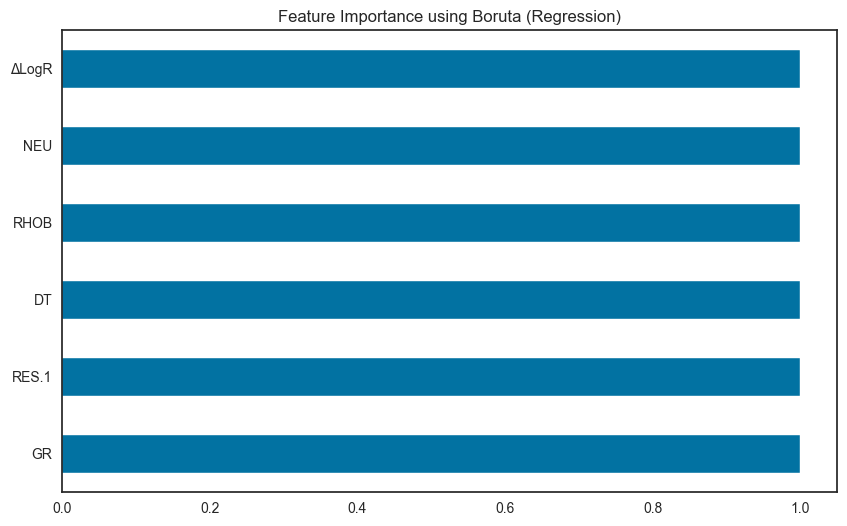

In [52]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Use a random forest regressor for Boruta
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize Boruta feature selector for regression
boruta_selector = BorutaPy(model, n_estimators='auto', random_state=42)

# Fit Boruta selector to data
boruta_selector.fit(X_KR2.values, y_KR2)

# Get the ranking of features
feature_ranks = boruta_selector.ranking_

# Convert to a Pandas Series for plotting
feature_ranks_series = pd.Series(feature_ranks, index=X_KR2.columns)

# Plot Boruta feature importance
plt.figure(figsize=(10, 6))
feature_ranks_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance using Boruta (Regression)')
plt.show()


KR3 Machine Learning Feature selection;

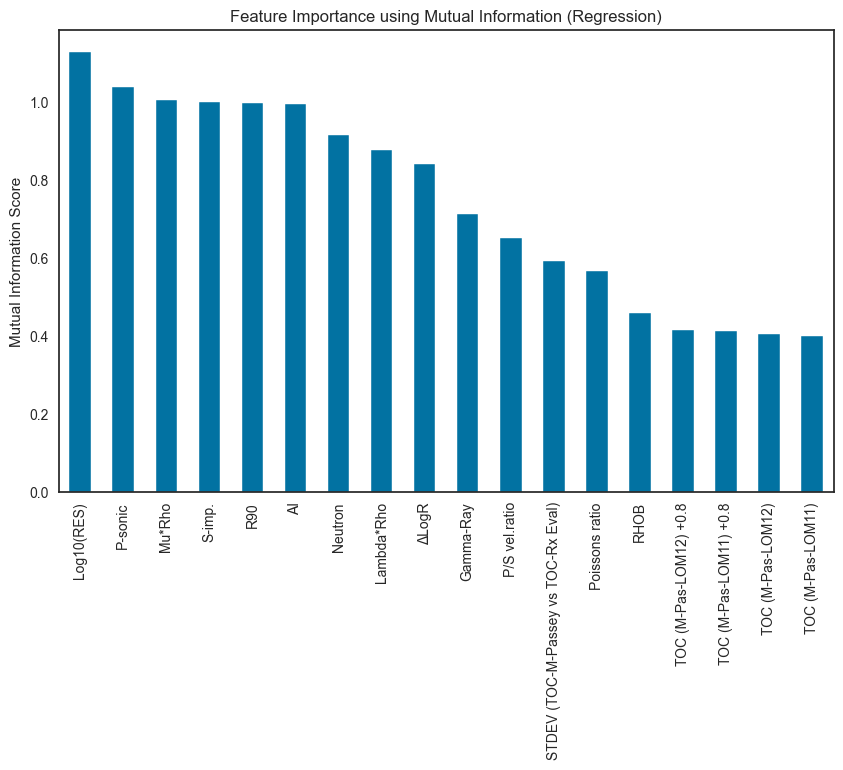

In [53]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd

# Compute Mutual Information for regression
mutual_info = mutual_info_regression(X_KR3, y_KR3)
mutual_info_series = pd.Series(mutual_info, index=X_KR3.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='bar')
plt.title('Feature Importance using Mutual Information (Regression)')
plt.ylabel('Mutual Information Score')
plt.show()


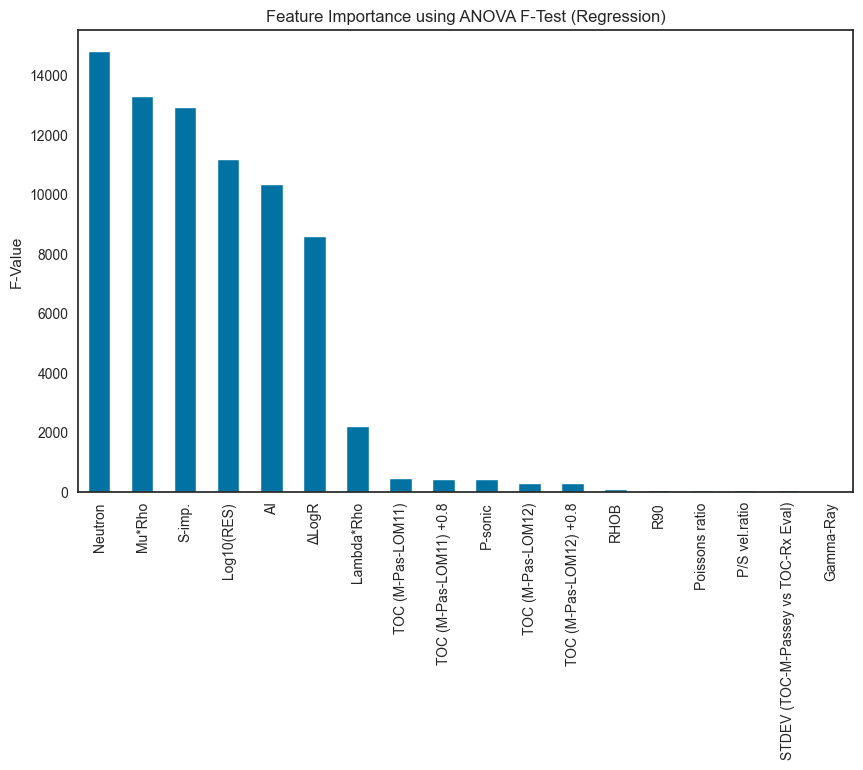

In [54]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt

# Apply ANOVA F-test for regression
selector = SelectKBest(f_regression, k='all')
selector.fit(X_KR3, y_KR3)

# Plot feature importance using F-values
plt.figure(figsize=(10, 6))
pd.Series(selector.scores_, index=X_KR3.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance using ANOVA F-Test (Regression)')
plt.ylabel('F-Value')
plt.show()


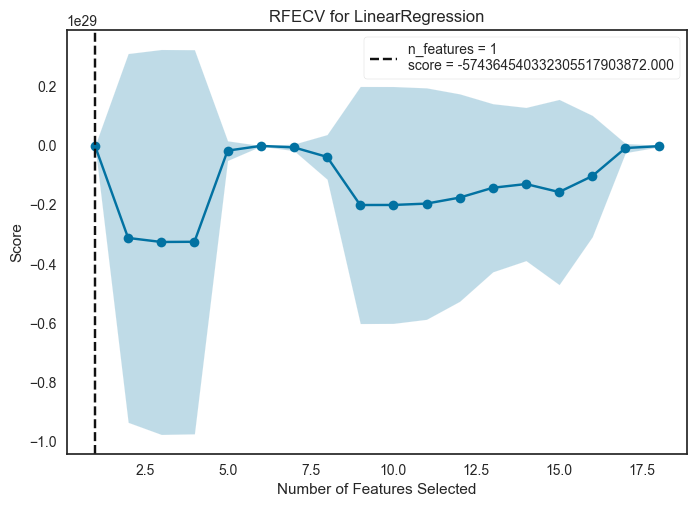

<Axes: title={'center': 'RFECV for LinearRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import RFECV

# Initialize the regression model (you can also try RandomForestRegressor or other regression models)
model = LinearRegression()

# Create the RFE visualizer for regression
visualizer = RFECV(model, cv=5, scoring='r2')  # Use R2 score for regression

visualizer.fit(X_KR3, y_KR3)  # Fit the data to the visualizer
visualizer.show()      # Finalize and render the figure


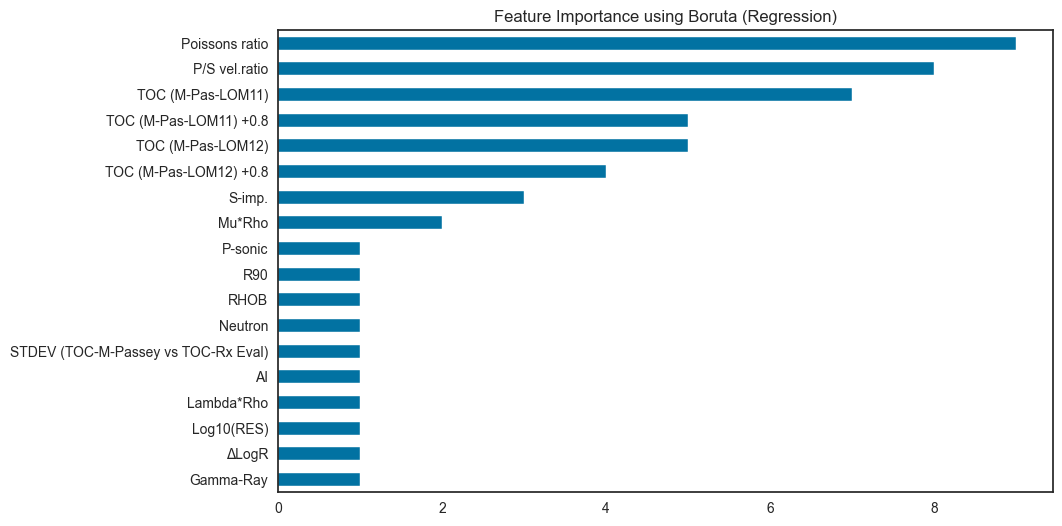

In [56]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Use a random forest regressor for Boruta
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize Boruta feature selector for regression
boruta_selector = BorutaPy(model, n_estimators='auto', random_state=42)

# Fit Boruta selector to data
boruta_selector.fit(X_KR3.values, y_KR3)

# Get the ranking of features
feature_ranks = boruta_selector.ranking_

# Convert to a Pandas Series for plotting
feature_ranks_series = pd.Series(feature_ranks, index=X_KR3.columns)

# Plot Boruta feature importance
plt.figure(figsize=(10, 6))
feature_ranks_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance using Boruta (Regression)')
plt.show()

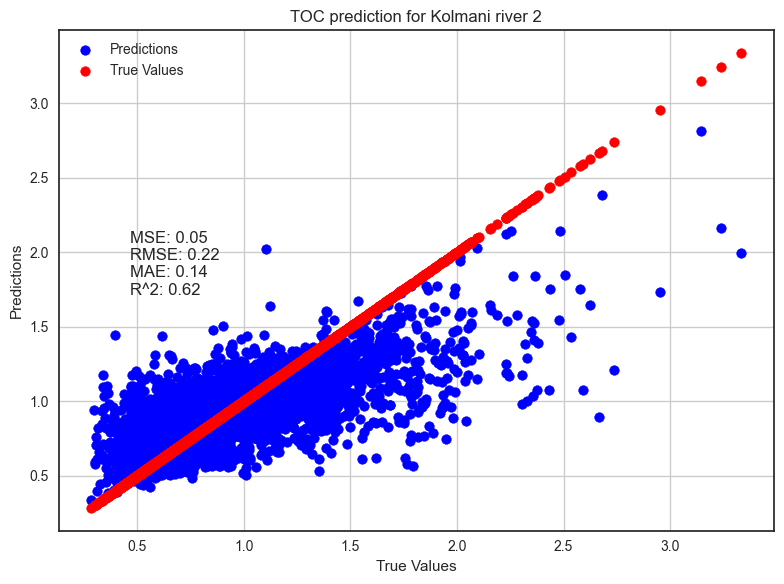

In [57]:
#run a quick regression model for KR2
def evaluate_regression_model(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the regression model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Plot true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predictions')  # Predicted values in blue
    plt.scatter(y_test, y_test, color='red', label='True Values')  # True values in red
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("TOC prediction for Kolmani river 2")
    plt.grid(True)
    plt.legend()

    # Display evaluation metrics on the chart
    metrics_text = f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR^2: {r_squared:.2f}"
    plt.text(0.1, 0.6, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()
evaluate_regression_model(X_KR2,y_KR2)

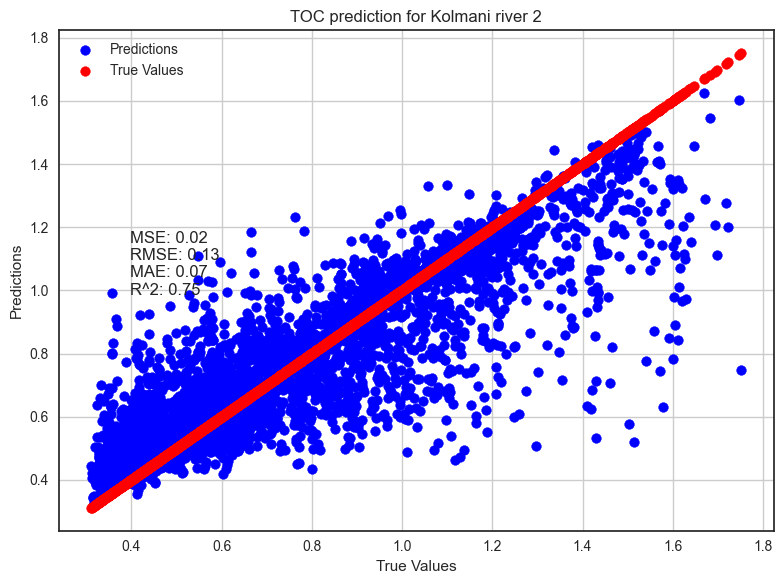

In [58]:
#run a quick regression model for KR3
evaluate_regression_model(X_KR3,y_KR3)

Investigate the model from a classification point. Here there is a classification boundary in Passey excel file, exactly on Sheet 1 of the file.

The category is as follows.
    if toc_value < 0.5:
        return 'Poor'
    elif 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 2:
        return 'Good'
    elif 2 <= toc_value < 4:
        return 'V.Good'
    else:
        return 'Excellent'
However, we will reformat this to binary class and have.

if 0.5 <= toc_value < 1:
        return 'Fair'
    elif 1 <= toc_value < 4:
        return 'Good'


In [59]:
def categorize_toc(toc_value):
    """
    Categorize Measured TOC values into qualitative labels.

    Parameters:
    toc_value (float): Measured TOC value.

    Returns:
    str: Categorical label.
    """
    if 0.5< toc_value < 1:
        return '0' #fair
    elif 1 <= toc_value < 4:
        return '1' #good

In [60]:
KR2_cla = KR2.copy()
KR3_cla = KR3.copy()

In [61]:
# Apply categorization function to 'Measured-TOC' column
KR2_cla['TOC_Category'] = KR2_cla['Measured-TOC'].apply(categorize_toc).astype(float)
KR3_cla['TOC_Category'] = KR3_cla['Measured-TOC'].apply(categorize_toc).astype(float)

In [62]:
KR2_cla.head()

,GR,RES.1,DT,RHOB,NEU,ΔLogR,Measured-TOC,TOC_Category
0,40.4902,1970.836,56.5478,1.6991,51.6765,1.556562,0.8686,0.0
1,40.3001,1968.455,56.0224,1.7037,53.4121,1.535021,0.8669,0.0
2,38.8794,1966.763,56.0224,1.7081,50.7708,1.534648,0.8652,0.0
3,37.9678,1966.763,55.3079,1.7130,57.6586,1.506068,0.8635,0.0
4,37.4406,1962.986,55.3079,1.7149,59.4048,1.505233,0.8618,0.0


In [63]:
KR3_cla.head()

,Gamma-Ray,R90,RHOB,Neutron,P-sonic,AI,S-imp.,P/S vel.ratio,Poissons ratio,Lambda*Rho,Mu*Rho,Log10(RES),ΔLogR,TOC (M-Pas-LOM11),TOC (M-Pas-LOM12),TOC (M-Pas-LOM11) +0.8,TOC (M-Pas-LOM12) +0.8,Measured-TOC,STDEV (TOC-M-Passey vs TOC-Rx Eval),TOC_Category
0,39.97,2000.0,0.0,0.5978,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,3.30103,-0.69897,-0.971983,-0.658959,-0.171983,0.141041,0.734000,0.085589,0.0
1,39.78,2000.0,0.0,0.6039,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,3.30103,-0.69897,-0.971983,-0.658959,-0.171983,0.141041,0.735271,0.078518,0.0
2,39.30,2000.0,0.0,0.5645,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,3.30103,-0.69897,-0.971983,-0.658959,-0.171983,0.141041,0.736542,0.078518,0.0
3,39.26,2000.0,0.0,0.5120,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,3.30103,-0.69897,-0.971983,-0.658959,-0.171983,0.141041,0.737813,0.071447,0.0
4,39.51,2000.0,0.0,0.5048,0.0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,3.30103,-0.69897,-0.971983,-0.658959,-0.171983,0.141041,0.739083,0.071447,0.0


In [64]:
# Drop 'MEasured-TOC' column from KR2 & KR3 dataframe
KR2_cla = KR2_cla.drop('Measured-TOC', axis=1)
KR3_cla = KR3_cla.drop('Measured-TOC', axis=1)

In [65]:
KR2_cla=KR2_cla.dropna()
KR3_cla=KR3_cla.dropna()

<Axes: xlabel='TOC_Category'>

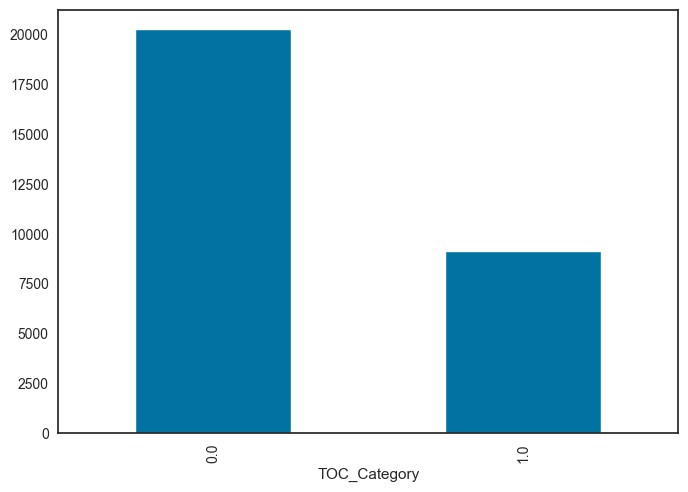

In [66]:
X = KR2_cla.drop('TOC_Category', axis=1)
y = KR2_cla['TOC_Category']

y.value_counts().plot.bar()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso

# Define the number of outer folds for nested cross-validation
n_outer_splits = 5

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': (GradientBoostingClassifier(), {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 200]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-7, 1e-5]}),
    'MLP': (MLPClassifier(activation='logistic'), {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2']}),
    'SVM Linear': (SVC(kernel='linear'), {'C': [0.1, 1, 10]}),
    'SVM Poly': (SVC(kernel='poly'), {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}),
    'SVM Radial': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}),
    'Lasso Logistic': (LogisticRegression(penalty='l1', solver='liblinear'), {'C': [0.1, 1, 10]}),
    'Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]})
}

# Define evaluation metrics
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

# Initialize stratified k-fold cross-validator for outer loop
outer_cv = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Define your feature matrix X and target vector y here
X = KR2_cla.drop('TOC_Category', axis=1)
y = KR2_cla['TOC_Category']

# Initialize a dictionary to store the best hyperparameters for each model
best_hyperparameters = {}

# Initialize dictionaries to store mean and standard deviation of scores for each metric
mean_scores = {metric: [] for metric in metrics}
std_scores = {metric: [] for metric in metrics}

# Iterate over each model
for name, (model, param_grid) in classifiers.items():
    print(f"Evaluating {name}:")

    # Initialize lists to store metric scores across outer folds
    mean_scores[name] = {metric: [] for metric in metrics}

    # Perform nested cross-validation
    for train_index, test_index in outer_cv.split(X, y):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Initialize stratified k-fold cross-validator for inner loop
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize dictionaries to store metric scores across inner folds
        inner_scores = {metric: [] for metric in metrics}

        # Perform inner cross-validation for hyperparameter tuning
        for inner_train_index, inner_val_index in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_val_index]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

            # Hyperparameter tuning using grid search
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
            grid_search.fit(X_train_inner, y_train_inner)
            best_model = grid_search.best_estimator_

            # Train the best model on the training fold of the inner loop
            best_model.fit(X_train_inner, y_train_inner)

            # Make predictions on the validation fold of the inner loop
            y_pred_inner = best_model.predict(X_val_inner)

            # Compute evaluation metrics for the inner fold
            for metric_name, metric_func in metrics.items():
                score = metric_func(y_val_inner, y_pred_inner)
                inner_scores[metric_name].append(score)

        # Compute mean scores across inner folds for each metric
        for metric_name in metrics.keys():
            mean_score = np.mean(inner_scores[metric_name])
            mean_scores[name][metric_name].append(mean_score)

    # Compute mean and standard deviation of scores across outer folds for each metric
    for metric_name in metrics.keys():
        mean_score = np.mean(mean_scores[name][metric_name])
        std_score = np.std(mean_scores[name][metric_name])
        print(f"Mean {metric_name}: {mean_score:.4f}, Std: {std_score:.4f}")

    # Find the best metric and its corresponding score
    best_metric = max(mean_scores[name], key=lambda x: np.mean(mean_scores[name][x]))
    best_mean_score = np.mean(mean_scores[name][best_metric])

    # Store the best hyperparameters for the model
    best_hyperparameters[name] = grid_search.best_params_

    print(f"Best {best_metric} Score: {best_mean_score:.4f}")
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print("\n")

Evaluating Gradient Boosting:
Mean accuracy: 0.7703, Std: 0.0010
Mean precision: 0.6619, Std: 0.0033
Mean recall: 0.5313, Std: 0.0023
Mean f1: 0.5893, Std: 0.0011
Best accuracy Score: 0.7703
Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 200}


Evaluating KNN:
Mean accuracy: 0.7611, Std: 0.0021
Mean precision: 0.6315, Std: 0.0035
Mean recall: 0.5532, Std: 0.0055
Mean f1: 0.5896, Std: 0.0043
Best accuracy Score: 0.7611
Best Hyperparameters: {'n_neighbors': 7}


Evaluating Naive Bayes:
Mean accuracy: 0.3207, Std: 0.0002
Mean precision: 0.3132, Std: 0.0001
Mean recall: 0.9974, Std: 0.0004
Mean f1: 0.4767, Std: 0.0001
Best recall Score: 0.9974
Best Hyperparameters: {'var_smoothing': 1e-09}


Evaluating MLP:


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.01, n_estimators=200),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Naive Bayes': GaussianNB(var_smoothing=1e-09),
    'MLP': MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(100,)),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_features='log2'),
    'SVM Linear': SVC(kernel='linear', C=0.1,probability=True),
    'SVM Poly': SVC(kernel='poly', C=0.1, degree=3,probability=True),
    'SVM Radial': SVC(kernel='rbf', C=1, gamma='scale',probability=True),
    'Logistic Regression': LogisticRegression(C=0.1, penalty='l2'),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=0.1),
    'Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(max_depth=30)
}

# Define your feature matrix X and target vector y here
X = KR2_cla.drop('TOC_Category', axis=1)
y = KR2_cla['TOC_Category']

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot ROC curve for each classifier with error bars
plt.figure(figsize=(10, 8))
for name, classifier in classifiers.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train, y_train)
        probas_ = classifier.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Compute error bars
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
X = KR3_cla.drop('TOC_Category', axis=1)
y = KR3_cla['TOC_Category']

y.value_counts().plot.bar()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso

# Define the number of outer folds for nested cross-validation
n_outer_splits = 5

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': (GradientBoostingClassifier(), {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 200]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Naive Bayes': (GaussianNB(), {'var_smoothing': [1e-9, 1e-7, 1e-5]}),
    'MLP': (MLPClassifier(activation='logistic'), {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2']}),
    'SVM Linear': (SVC(kernel='linear'), {'C': [0.1, 1, 10]}),
    'SVM Poly': (SVC(kernel='poly'), {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}),
    'SVM Radial': (SVC(kernel='rbf'), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}),
    'Lasso Logistic': (LogisticRegression(penalty='l1', solver='liblinear'), {'C': [0.1, 1, 10]}),
    'Discriminant Analysis': (LinearDiscriminantAnalysis(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]})
}

# Define evaluation metrics
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

# Initialize stratified k-fold cross-validator for outer loop
outer_cv = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Define your feature matrix X and target vector y here
X = KR3_cla.drop('TOC_Category', axis=1)
y = KR3_cla['TOC_Category']

# Initialize a dictionary to store the best hyperparameters for each model
best_hyperparameters = {}

# Initialize dictionaries to store mean and standard deviation of scores for each metric
mean_scores = {metric: [] for metric in metrics}
std_scores = {metric: [] for metric in metrics}

# Iterate over each model
for name, (model, param_grid) in classifiers.items():
    print(f"Evaluating {name}:")

    # Initialize lists to store metric scores across outer folds
    mean_scores[name] = {metric: [] for metric in metrics}

    # Perform nested cross-validation
    for train_index, test_index in outer_cv.split(X, y):
        X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

        # Initialize stratified k-fold cross-validator for inner loop
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Initialize dictionaries to store metric scores across inner folds
        inner_scores = {metric: [] for metric in metrics}

        # Perform inner cross-validation for hyperparameter tuning
        for inner_train_index, inner_val_index in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_index], X_train_outer.iloc[inner_val_index]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_index], y_train_outer.iloc[inner_val_index]

            # Hyperparameter tuning using grid search
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
            grid_search.fit(X_train_inner, y_train_inner)
            best_model = grid_search.best_estimator_

            # Train the best model on the training fold of the inner loop
            best_model.fit(X_train_inner, y_train_inner)

            # Make predictions on the validation fold of the inner loop
            y_pred_inner = best_model.predict(X_val_inner)

            # Compute evaluation metrics for the inner fold
            for metric_name, metric_func in metrics.items():
                score = metric_func(y_val_inner, y_pred_inner)
                inner_scores[metric_name].append(score)

        # Compute mean scores across inner folds for each metric
        for metric_name in metrics.keys():
            mean_score = np.mean(inner_scores[metric_name])
            mean_scores[name][metric_name].append(mean_score)

    # Compute mean and standard deviation of scores across outer folds for each metric
    for metric_name in metrics.keys():
        mean_score = np.mean(mean_scores[name][metric_name])
        std_score = np.std(mean_scores[name][metric_name])
        print(f"Mean {metric_name}: {mean_score:.4f}, Std: {std_score:.4f}")

    # Find the best metric and its corresponding score
    best_metric = max(mean_scores[name], key=lambda x: np.mean(mean_scores[name][x]))
    best_mean_score = np.mean(mean_scores[name][best_metric])

    # Store the best hyperparameters for the model
    best_hyperparameters[name] = grid_search.best_params_

    print(f"Best {best_metric} Score: {best_mean_score:.4f}")
    print(f"Best Hyperparameters: {best_hyperparameters[name]}")
    print("\n")

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# Define classifiers and their hyperparameter grids
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.01, n_estimators=200),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Naive Bayes': GaussianNB(var_smoothing=1e-09),
    'MLP': MLPClassifier(activation='logistic', alpha=0.0001, hidden_layer_sizes=(100,)),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_features='log2'),
    'SVM Linear': SVC(kernel='linear', C=0.1,probability=True),
    'SVM Poly': SVC(kernel='poly', C=0.1, degree=3,probability=True),
    'SVM Radial': SVC(kernel='rbf', C=1, gamma='scale',probability=True),
    'Logistic Regression': LogisticRegression(C=0.1, penalty='l2'),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=0.1),
    'Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(max_depth=30)
}

# Define your feature matrix X and target vector y here
X = KR3_cla.drop('TOC_Category', axis=1)
y = KR3_cla['TOC_Category']

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot ROC curve for each classifier with error bars
plt.figure(figsize=(10, 8))
for name, classifier in classifiers.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        classifier.fit(X_train, y_train)
        probas_ = classifier.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Compute error bars
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
